<a href="https://colab.research.google.com/github/pavanghorpade60/Project-2-stock-market-prediction-ARIMA/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#1
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
#📅
from datetime import datetime # Import datetime
start_date="2020-01-01"
end_date_forecast="2025-09-13"
#datetime.now().strftime('%Y-%m-%d')
print(f"\nTODAY:{end_date_forecast}")

# 1. Download data
#📊
ticker="BAJAJFINSV.NS"
data = yf.download(ticker, start= start_date, end=end_date_forecast)
d_high=data["High"]

length = len(data)
print("\n=================================================================")
print(f"Company:{ticker}")
print(f"Length:{length}")
print("\n=================================================================")
print(d_high.tail(5))


TODAY:2025-09-13


/tmp/ipython-input-746140497.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start= start_date, end=end_date_forecast)
[*********************100%***********************]  1 of 1 completed


Company:BAJAJFINSV.NS
Length:1414

Ticker      BAJAJFINSV.NS
Date                     
2025-09-08    2026.400024
2025-09-09    2039.000000
2025-09-10    2047.000000
2025-09-11    2048.800049
2025-09-12    2089.000000


Epoch 1/500


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


139/139 - 10s - 70ms/step - loss: 0.0117
Epoch 2/500
139/139 - 4s - 29ms/step - loss: 0.0012
Epoch 3/500
139/139 - 6s - 44ms/step - loss: 7.7766e-04
Epoch 4/500
139/139 - 4s - 29ms/step - loss: 4.0646e-04
Epoch 5/500
139/139 - 7s - 49ms/step - loss: 3.3388e-04
Epoch 6/500
139/139 - 4s - 29ms/step - loss: 1.7518e-04
Epoch 7/500
139/139 - 4s - 29ms/step - loss: 1.5944e-04
Epoch 8/500
139/139 - 5s - 36ms/step - loss: 1.4061e-04
Epoch 9/500
139/139 - 4s - 29ms/step - loss: 7.8151e-05
Epoch 10/500
139/139 - 4s - 29ms/step - loss: 5.6567e-05
Epoch 11/500
139/139 - 5s - 36ms/step - loss: 5.8470e-05
Epoch 12/500
139/139 - 4s - 29ms/step - loss: 5.1909e-05
Epoch 13/500
139/139 - 5s - 37ms/step - loss: 5.9344e-05
Epoch 14/500
139/139 - 5s - 38ms/step - loss: 5.0970e-05
Epoch 15/500
139/139 - 4s - 29ms/step - loss: 7.6802e-05
Epoch 16/500
139/139 - 5s - 36ms/step - loss: 4.3646e-05
Epoch 17/500
139/139 - 4s - 29ms/step - loss: 3.4381e-05
Epoch 18/500
139/139 - 4s - 29ms/step - loss: 3.1675e-05
Ep

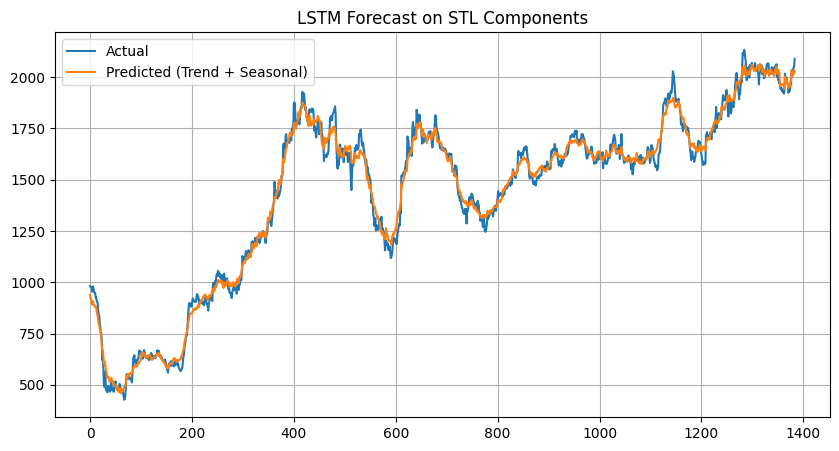

📉 Final RMSE (Reconstructed): 37.7468
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
📅 Forecast for Next Day (Trend + Seasonal): 1964.8651


In [6]:
from statsmodels.tsa.seasonal import STL

# ✅ 1. STL Decomposition
stl = STL(d_high, period=30)  # adjust period as needed
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
resid = result.resid  # optional

# ✅ 2. Sequence Preparation Function
def prepare_lstm_data(series, window_size):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series.values.reshape(-1, 1))
    X, y = [], []
    for i in range(len(scaled) - window_size):
        X.append(scaled[i:i+window_size])
        y.append(scaled[i+window_size])
    return np.array(X), np.array(y), scaler

window_size = 30
X_trend, y_trend, scaler_trend = prepare_lstm_data(trend, window_size)
X_seasonal, y_seasonal, scaler_seasonal = prepare_lstm_data(seasonal, window_size)

# ✅ 3. LSTM Builder
def build_and_train_lstm(X, y, epochs=500):
    model = Sequential([
        LSTM(50,return_sequences=True, input_shape=(X.shape[1], 1)),
        LSTM(50,return_sequences=True),
        LSTM(50, return_sequences=False),

        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=10, verbose=2)
    return model

# ✅ 4. Train Models
model_trend = build_and_train_lstm(X_trend, y_trend)
model_seasonal = build_and_train_lstm(X_seasonal, y_seasonal)

# ✅ 5. Predictions & Inverse Scaling
y_trend_pred = model_trend.predict(X_trend)
y_seasonal_pred = model_seasonal.predict(X_seasonal)

trend_pred = scaler_trend.inverse_transform(y_trend_pred)
seasonal_pred = scaler_seasonal.inverse_transform(y_seasonal_pred)

# ✅ 6. Final Forecast
final_pred = trend_pred.flatten() + seasonal_pred.flatten()
actual = d_high.values[window_size:]

# ✅ 7. Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(actual, label="Actual")
plt.plot(final_pred, label="Predicted (Trend + Seasonal)")
plt.title("LSTM Forecast on STL Components")
plt.legend()
plt.grid(True)
plt.show()

# ✅ 8. RMSE
rmse = np.sqrt(mean_squared_error(actual, final_pred))
print(f"📉 Final RMSE (Reconstructed): {rmse:.4f}")

# ✅ Forecast 1-step ahead for Trend
last_trend_window = trend.values[-window_size:].reshape(1, window_size, 1)
last_trend_scaled = scaler_trend.transform(last_trend_window.reshape(window_size, 1)).reshape(1, window_size, 1)
next_trend_scaled = model_trend.predict(last_trend_scaled)
next_trend = scaler_trend.inverse_transform(next_trend_scaled)[0][0]

# ✅ Forecast 1-step ahead for Seasonal
last_seasonal_window = seasonal.values[-window_size:].reshape(1, window_size, 1)
last_seasonal_scaled = scaler_seasonal.transform(last_seasonal_window.reshape(window_size, 1)).reshape(1, window_size, 1)
next_seasonal_scaled = model_seasonal.predict(last_seasonal_scaled)
next_seasonal = scaler_seasonal.inverse_transform(next_seasonal_scaled)[0][0]

# ✅ Final Forecast
next_day_forecast_high_LSTM = next_trend + next_seasonal
print(f"📅 Forecast for Next Day (Trend + Seasonal): {next_day_forecast_high_LSTM:.4f}")